In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.pyplot import cm
import scipy.special as sp
from scipy.optimize import least_squares
import os 
from lmfit import minimize, Parameters, Parameter, report_fit,Model
%matplotlib inline

# plot style
#plt.style.reload_library()
#plot_style = {'notebook':'../include/notebook.mplstyle','aps':'../include/IOP_Large.mplstyle'}


#figsize = plt.rcParams['figure.figsize'] 
plt.rcParams ["figure.dpi"] = 120

%config InlineBackend.figure_format = 'retina'

In [2]:
filenames=os.listdir('../data/ed')
filenamesdmrg = os.listdir('../data/dmrg')

In [3]:
filenames.remove('.ipynb_checkpoints')
filenamesdmrg.remove('.ipynb_checkpoints')

In [4]:
def loaddata(α,v,ln):
    N=[]
    oneN=[]
    ent=[] 
    for i in range(len(filenames)):    
        fn = filenames[i]
        n = int(fn.split("_")[2][1:])
        Nval = int(fn.split("_")[4][1:])
        if Nval > 10 and n == ln:
            with open('../data/ed/'+fn,"r",encoding="utf-8",errors='ignore') as file:
                lines = file.readlines()
                nLines = len(lines)
            data = np.loadtxt('../data/ed/'+fn,encoding="utf-8", max_rows=nLines-4)    
            try:
                V  = data[:,0]
                S1 = data[:,α]
            except IndexError:
                V = np.array([data[0]])
                S1 = np.array([data[α]])
            if v in V:
                N.append(Nval)
                oneN.append(1/Nval)
                idx = np.where(V==v)
                ent.append(np.exp(-S1[idx]))
    for i in range(len(filenamesdmrg)):    
        fn = filenamesdmrg[i]
        n = int(fn.split("_")[2][1:])
        Nval = int(fn.split("_")[4][1:])
        if Nval > 10 and n==ln:
            with open('../data/dmrg/'+fn,"r",encoding="utf-8",errors='ignore') as file:
                lines = file.readlines()
                nLines = len(lines)
            data = np.loadtxt('../data/dmrg/'+fn,encoding="utf-8", max_rows=nLines-4)    
            try:
                V  = data[:,0]
                S1 = data[:,α]
            except IndexError:
                V = np.array([data[0]])
                S1 = np.array([data[α]])
            if v in V:
                N.append(Nval)
                oneN.append(1/Nval)
                idx = np.where(V==v)
                ent.append(np.exp(-S1[idx]))
    return N, oneN,ent

In [5]:
def gammasq(v):
    k = np.pi/(2*np.arccos(-v/2))
    γ=np.sqrt((k+1/k-2)/2)
    return γ**2

In [6]:
def g(v):
    k = np.pi/(2*np.arccos(-v/2))
    g=(k+1/k-2)/4
    return g
print(g(-1.65))

0.2494385428195225


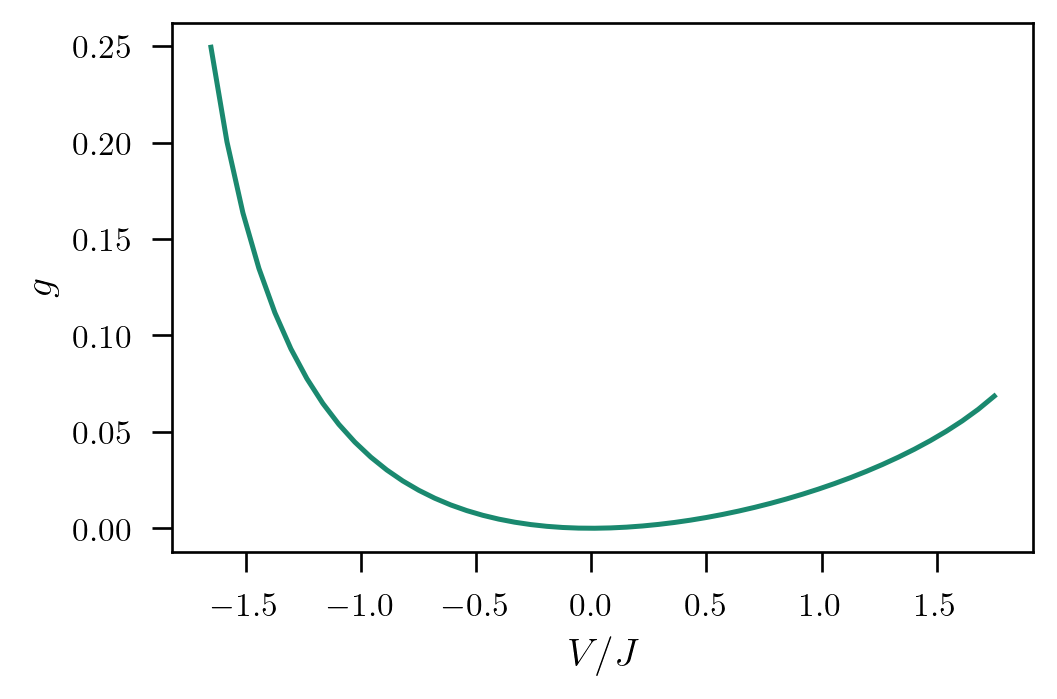

In [199]:
plt.style.reload_library()
with plt.style.context('../include/IOP.mplstyle'):
    vs = np.linspace(-1.65,1.75)
    gvals = [g(v) for v in vs]
    plt.plot(vs,gvals,color="#1A896F")
    plt.xlabel(r'$V/J$')
    plt.ylabel(r'$g$')
    plt.savefig('gvalues.pdf')

In [7]:
colors=["#0B2456","#1A896F","#bdd73c","#FF9F1C","#E71D36"]

In [8]:
from scipy.optimize import curve_fit

In [29]:
from functools import partial
def scalingform(x,c1,c2,c3,c4,c5,v):
    exp = 2*gammasq(v)
    return c1*x**4+c2*x**(3+exp)+c3*x**2+c4*x**(1+exp)+c5

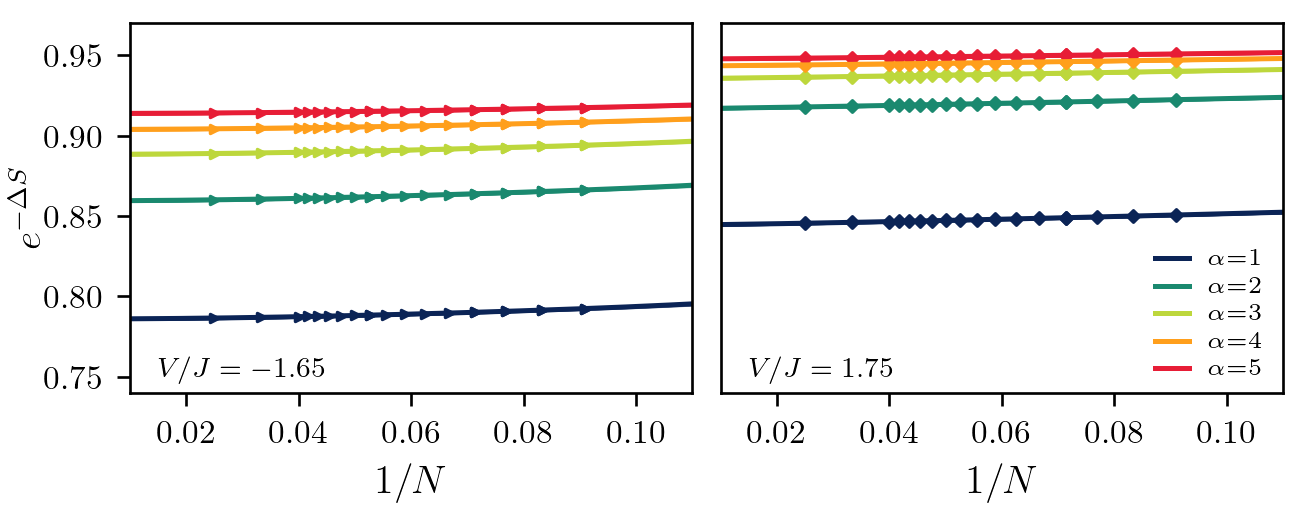

In [249]:
def fitfunc(x,a,b,c,d):
    return a*x**6+b*x**4+c*x**2+d
plt.style.reload_library()
with plt.style.context('../include/IOP.mplstyle'):
    fig, axs = plt.subplots(1,2,sharey=True)
    plt.subplots_adjust(wspace=.05) 
    ax1 = axs[0]
    v=-1.65
    for i,α in enumerate([5,4,3,2,1]):
        nval=1
        N, oneN, ent = loaddata(α,v,nval)
        oneN=np.array(oneN)
        ent = np.array(ent)
        ent=ent.reshape((-1,))
        fit, cov= curve_fit(fitfunc, oneN, ent)
        perr = np.sqrt(np.diag(cov))
        ratios=np.linspace(.01,.11,1000)
        #plt.plot(ratios,fitfunc(ratios,*fit),color=colors[i],label=f'α={α}:'+(r'$(%.3e\pm%.3e)\frac{1}{N^{4}}+(%.3e\pm%.3e)\frac{1}{N^{3.27}}+(%.3e\pm%.3e)\frac{1}{N^{2}}+(%.3e\pm%.3e)\frac{1}{N^{1.27}}+(%.3e\pm%.3e)$'%(fit[0],perr[0],fit[1],perr[1],fit[2],perr[2],fit[3],perr[3],fit[4],perr[4])))
        ax1.plot(ratios,fitfunc(ratios,*fit),color=colors[α-1])
        ax1.fill_between(ratios,fitfunc(ratios,*fit),fitfunc(ratios,*fit+perr),color=colors[α-1],alpha=.5)
        ax1.fill_between(ratios,fitfunc(ratios,*fit),fitfunc(ratios,*fit-perr),color=colors[α-1],alpha=.5) 
        for j in range(len(ent)):
            ax1.scatter(oneN[j],ent[j],marker = '>',color=colors[α-1],s=6)
        #ax1.text(.121,fitfunc(.11,*fit),rf"$\alpha$={α}",ha="right",va="center",color=colors[i],size='xx-small')
    ax1.text(.015,.75,r'$V/J=-1.65$',size='x-small')
    ax1.set_xlabel(r'$1/N$')
    ax1.set_xlim(.01,.11)
    
    ax2 = axs[1]
    v=1.75
    for i,α in enumerate([1,2,3,4,5]):
            nval=1
            N, oneN, ent = loaddata(α,v,nval)
            oneN=np.array(oneN)
            ent = np.array(ent)
            ent=ent.reshape((-1,))
            scalingv=partial(scalingform,v=v)
            fit, cov= curve_fit(scalingv, oneN, ent)
            perr = np.sqrt(np.diag(cov))
            ratios=np.linspace(.01,.11,1000)
            #plt.plot(ratios,fitfunc(ratios,*fit),color=colors[i],label=f'α={α}:'+(r'$(%.3e\pm%.3e)\frac{1}{N^{4}}+(%.3e\pm%.3e)\frac{1}{N^{3.27}}+(%.3e\pm%.3e)\frac{1}{N^{2}}+(%.3e\pm%.3e)\frac{1}{N^{1.27}}+(%.3e\pm%.3e)$'%(fit[0],perr[0],fit[1],perr[1],fit[2],perr[2],fit[3],perr[3],fit[4],perr[4])))
            ax2.plot(ratios, scalingv(ratios,*fit),color=colors[i],label=rf'$\alpha$={α}')
            ax2.fill_between(ratios, scalingv(ratios,*fit), scalingv(ratios,*fit+perr),color=colors[i],alpha=.5)
            ax2.fill_between(ratios, scalingv(ratios,*fit), scalingv(ratios,*fit-perr),color=colors[i],alpha=.5) 
            #for j in range(len(ent)):
            ax2.scatter(oneN,ent,marker = 'D',color=colors[i],s=6)
    ax2.set_xlabel(r'$1/N$')
    ax2.legend(loc='lower right',fontsize='xx-small',bbox_to_anchor=(1,-.02),handlelength=1.5,handleheight=.2,labelspacing=.3)
    ax2.yaxis.set_tick_params(left=False)
    #plt.title(rf'n=1,v={v}, $2\gamma^2+1$=%.2f'%(1.27)) 
    ax2.set_xlim(.01,.11)
    ax2.text(.015,.75,r'$V/J=1.75$',size='x-small')
    #for ax in fig.get_axes():
     #   ax.label_outer()
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.ylabel(r'$e^{-\Delta S}$')
    ax1.set_ylim(.74,.97)
    plt.savefig('n1diffalphas.pdf')
    plt.show()

In [ ]:
def fitfunc1(x,b,c,d):
    return b*x**4+c*x**2+d
from functools import partial
def scalingform(x,c1,c2,c3,c4,c5,v):
    exp = 2*gammasq(v)
    return c1*x**4+c2*x**(3+exp)+c3*x**2+c4*x**(1+exp)+c5

$v=-1.65$:$(-1.01091e+01\pm6.590e-01)\frac{1}{N^{4}}+(8.55475e-01\pm6.084e-03)\frac{1}{N^{2}}+(7.859199e-01\pm1.156e-05)$
$v=-1.0$:$(2.35726e+00\pm1.689e-01)\frac{1}{N^{4}}+(-9.20670e-01\pm4.903e-02)\frac{1}{N^{3.27}}+(1.445935e-01\pm2.711e-03)\frac{1}{N^{2}}+(9.011387e-02\pm1.667e-04)\frac{1}{N^{1.27}}+(9.02117955e-01\pm9.496e-07)$
$v=1.65$:$(1.62779e+00\pm6.488e-02)\frac{1}{N^{4}}+(-6.93701e-01\pm2.042e-02)\frac{1}{N^{3.27}}+(5.928688e-02\pm9.268e-04)\frac{1}{N^{2}}+(1.143655e-01\pm7.058e-05)\frac{1}{N^{1.27}}+(8.55380409e-01\pm2.804e-07)$
$v=1.75$:$(1.27961e+00\pm5.198e-02)\frac{1}{N^{4}}+(-5.50889e-01\pm1.726e-02)\frac{1}{N^{3.27}}+(3.098267e-02\pm7.103e-04)\frac{1}{N^{2}}+(1.317115e-01\pm6.146e-05)\frac{1}{N^{1.27}}+(8.44206194e-01\pm2.017e-07)$


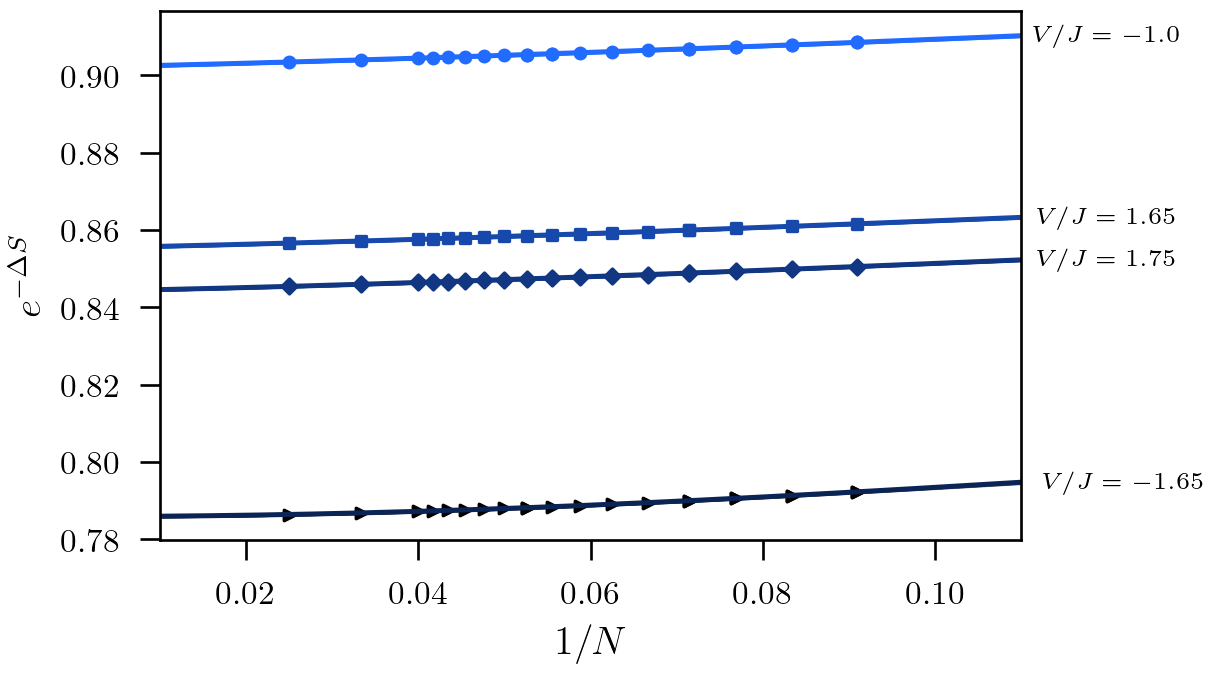

In [43]:
markers = {-1.65:'>',-1:'o',1.65:'s',1.75:'D'}
#coloralpha={-1.65:'#000000',1.75:'#0B2456',1.65:'#113782',-1:'#1749AD'}
coloralpha1={-1.65:'#000000',1.75:'#113782',1.65:'#1749AD',-1:'#216BFF'}
plt.style.reload_library()
with plt.style.context('../include/IOP.mplstyle'):
    fig,ax=plt.subplots()
    for i,v in enumerate([-1.65,-1.0,1.65,1.75]):
            nval=1
            α=1
            N, oneN, ent = loaddata(α,v,nval)
            oneN=np.array(oneN)
            ent = np.array(ent)
            ent=ent.reshape((-1,))
            if v == -1.65:
                fit, cov= curve_fit(fitfunc1, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                ratios=np.linspace(.01,.11,1000)
                print(rf'$v={v}$:'+(r'$(%.5e\pm%.3e)\frac{1}{N^{4}}+(%.5e\pm%.3e)\frac{1}{N^{2}}+(%.6e\pm%.3e)$'%(fit[0],perr[0],fit[1],perr[1],fit[2],perr[2])))
                plt.plot(ratios,fitfunc1(ratios,*fit),color=colors[i],label=f'α={α}')
                plt.fill_between(ratios,fitfunc1(ratios,*fit),fitfunc1(ratios,*fit+perr),color=coloralpha1[v],alpha=.5)
                plt.fill_between(ratios,fitfunc1(ratios,*fit),fitfunc1(ratios,*fit-perr),color=coloralpha1[v],alpha=.5) 
                for j in range(len(ent)):
                    plt.scatter(oneN[j],ent[j],marker = markers[v],color=coloralpha1[v],s=10)
                plt.text(.122,fitfunc1(.11,*fit),rf"$V/J={v}$",ha="center",va="center",size='xx-small')
            else: 
                scalingv=partial(scalingform,v=v)
                fit, cov= curve_fit(scalingv, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                #ratios=np.linspace(.01,.11,1000)
                #print(rf'$v={v}$:'+(r'$(%.5e\pm%.3e)\frac{1}{N^{4}}+(%.5e\pm%.3e)\frac{1}{N^{3.27}}+(%.6e\pm%.3e)\frac{1}{N^{2}}+(%.6e\pm%.3e)\frac{1}{N^{1.27}}+(%.8e\pm%.3e)$'%(fit[0],perr[0],fit[1],perr[1],fit[2],perr[2],fit[3],perr[3],fit[4],perr[4])))
                plt.plot(ratios,scalingv(ratios,*fit),color=coloralpha1[v],label=f'α={α}')
                plt.fill_between(ratios,scalingv(ratios,*fit),scalingv(ratios,*fit+perr),color=coloralpha1[v],alpha=.5)
                plt.fill_between(ratios,scalingv(ratios,*fit),scalingv(ratios,*fit-perr),color=coloralpha1[v],alpha=.5) 
                for j in range(len(ent)):
                    plt.scatter(oneN[j],ent[j],marker = markers[v],color=coloralpha1[v],s=10)
                plt.text(.12,scalingv(.11,*fit),rf"$V/J={v}$",ha="center",va="center",size='xx-small')
    ax.set_xlabel(r'$1/N$')
    ax.set_ylabel(r'$e^{-\Delta S}$')
    #plt.legend(loc="upper center",bbox_to_anchor=(3.2,.8))
    plt.xlim(.01,.11)
    plt.savefig('alpha1diffV.pdf')
    plt.show()


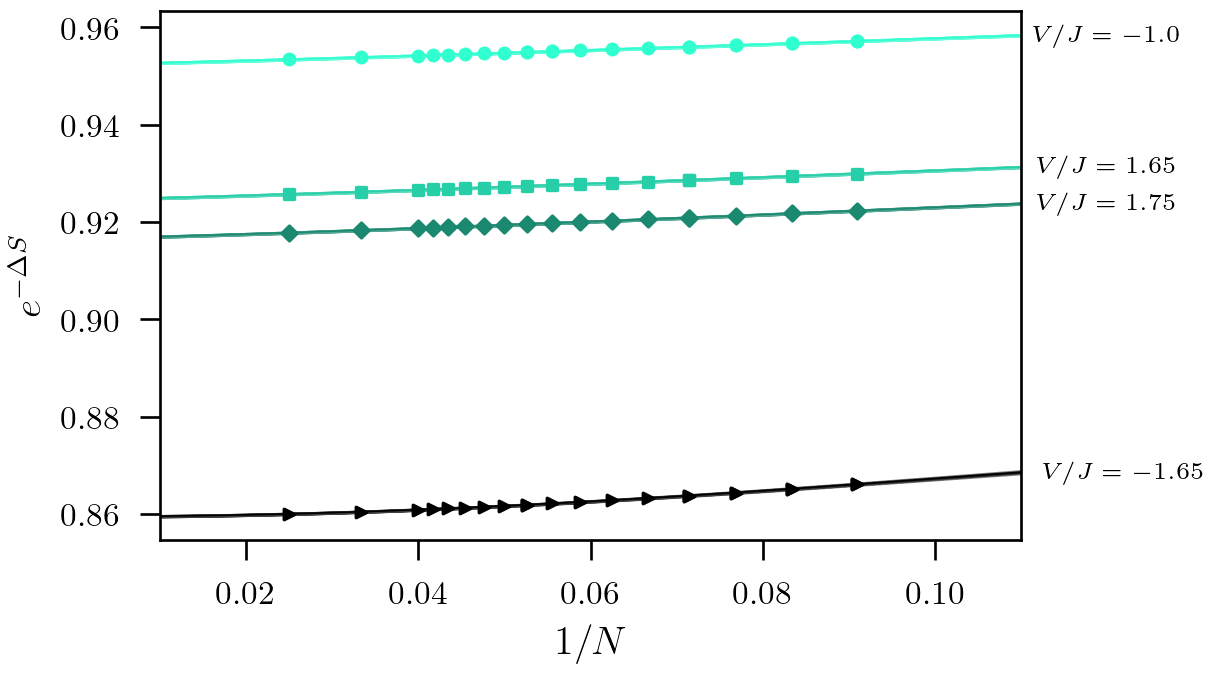

In [224]:
markers = {-1.65:'>',-1:'o',1.65:'s',1.75:'D'}
#coloralpha2={-1.65:'#000000',1.75:"#115948",1.65:'#1A896F',-1:'#27CFA8'}
coloralpha2={-1.65:'#000000',1.75:'#1A896F',1.65:'#27CFA8',-1:'#30FFCF'}
plt.style.reload_library()
with plt.style.context('../include/IOP.mplstyle'):
    fig,ax=plt.subplots()
    for i,v in enumerate([-1.65,-1.0,1.65,1.75]):
            nval=1
            α=2
            N, oneN, ent = loaddata(α,v,nval)
            oneN=np.array(oneN)
            ent = np.array(ent)
            ent=ent.reshape((-1,))
            if v == -1.65:
                fit, cov= curve_fit(fitfunc1, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                ratios=np.linspace(.01,.11,1000)
                plt.plot(ratios,fitfunc1(ratios,*fit),linewidth=.5,color=coloralpha2[v],label=rf'$\alpha={α}$:'+(r'$(%.3e\pm%.3e)\frac{1}{N^{4}}+(%.3e\pm%.3e)\frac{1}{N^{2}}+(%.3e\pm%.3e)$'%(fit[0],perr[0],fit[1],perr[1],fit[2],perr[2])))
                #plt.plot(ratios,fitfunc(ratios,*fit),color=colors[i],label=f'α={α}')
                plt.fill_between(ratios,fitfunc1(ratios,*fit),fitfunc1(ratios,*fit+perr),color=coloralpha2[v],alpha=.5)
                plt.fill_between(ratios,fitfunc1(ratios,*fit),fitfunc1(ratios,*fit-perr),color=coloralpha2[v],alpha=.5) 
                for j in range(len(ent)):
                    plt.scatter(oneN[j],ent[j],marker = markers[v],color=coloralpha2[v],s=10)
                plt.text(.122,fitfunc1(.11,*fit),rf"$V/J={v}$",ha="center",va="center",size='xx-small')
            else: 
                scalingv=partial(scalingform,v=v)
                fit, cov= curve_fit(scalingv, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                #ratios=np.linspace(.01,.11,1000)
                #plt.plot(ratios,scalingv(ratios,*fit),color=colors[i],label=rf'$\alpha={α}$:'+(r'$(%.3e\pm%.3e)\frac{1}{N^{4}}+(%.3e\pm%.3e)\frac{1}{N^{3.27}}+(%.3e\pm%.3e)\frac{1}{N^{2}}+(%.3e\pm%.3e)\frac{1}{N^{1.27}}+(%.3e\pm%.3e)$'%(fit[0],perr[0],fit[1],perr[1],fit[2],perr[2],fit[3],perr[3],fit[4],perr[4])))
                plt.plot(ratios,scalingv(ratios,*fit),linewidth=.5,color=coloralpha2[v],label=f'α={α}')
                plt.fill_between(ratios,scalingv(ratios,*fit),scalingv(ratios,*fit+perr),color=coloralpha2[v],alpha=.5)
                plt.fill_between(ratios,scalingv(ratios,*fit),scalingv(ratios,*fit-perr),color=coloralpha2[v],alpha=.5) 
                for j in range(len(ent)):
                    plt.scatter(oneN[j],ent[j],marker = markers[v],color=coloralpha2[v],s=10)
                plt.text(.12,scalingv(.11,*fit),rf"$V/J={v}$",ha="center",va="center",size='xx-small')
    ax.set_xlabel(r'$1/N$')
    ax.set_ylabel(r'$e^{-\Delta S}$')
    #plt.legend()
       #plt.title(rf'n=1,v={v}, $2\gamma^2+1$=%.2f'%(1.27)) 
    plt.xlim(.01,.11)
    #plt.savefig('alpha2diffV.pdf')
    plt.show()


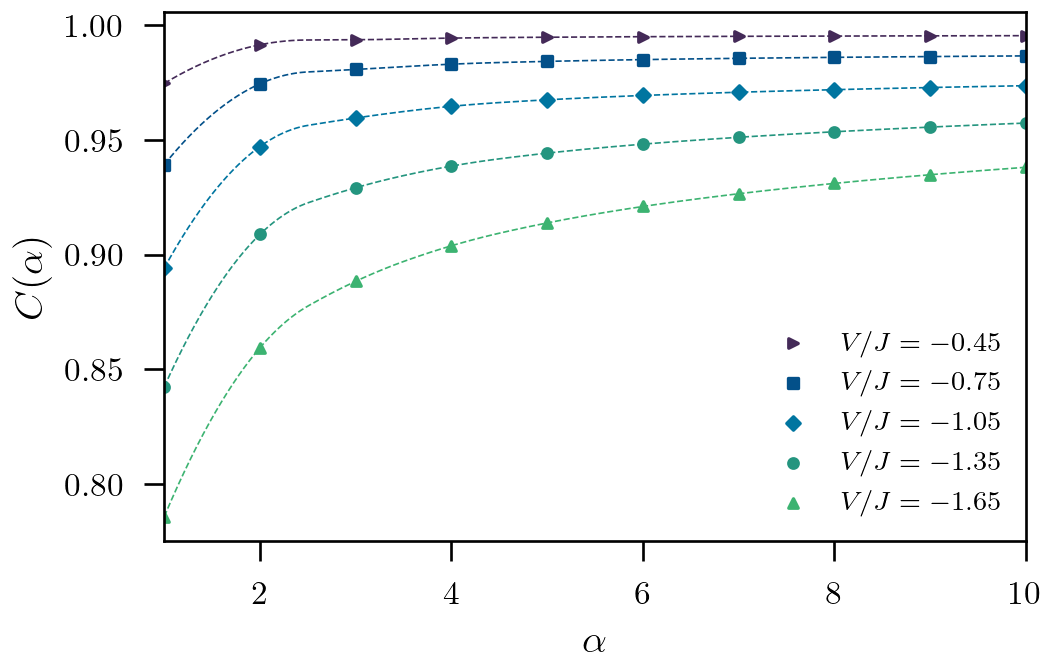

In [217]:
from scipy import interpolate
colors=['#442a58','#035089','#0075a0','#24957F','#3CB371']
markers=['>','s','D','o','^']
alphas=[1,2,3,4,5,6,7,8,9,10]
alphainterp=np.linspace(1,10,1000)
plt.style.reload_library()
with plt.style.context('../include/IOP.mplstyle'):
    fig,ax=plt.subplots()
    for i,v in enumerate([-.45,-.75,-1.05,-1.35,-1.65]):
            cα=[]
            cerror=[]
            for α in alphas:
                nval=1
                N, oneN, ent = loaddata(α,v,nval)
                oneN=np.array(oneN)
                ent = np.array(ent)
                ent=ent.reshape((-1,))
                if v == -1.65:
                    fit, cov= curve_fit(fitfunc1, oneN, ent)
                    perr = np.sqrt(np.diag(cov))
                    cα.append(fit[2])
                    cerror.append(perr[2]) 
                else:
                    scalingv=partial(scalingform,v=v)
                    fit, cov= curve_fit(scalingv, oneN, ent)
                    perr = np.sqrt(np.diag(cov))
                    cα.append(fit[4])
                    cerror.append(perr[4])
            f=interpolate.interp1d(alphas,cα,kind='quadratic')
            plt.plot(alphainterp,f(alphainterp),linestyle='--',linewidth=.5,color=colors[i])
            plt.scatter(alphas,cα,marker=markers[i],s=8,color=colors[i],label=rf'$V/J={v}$')
           # if v == -1.65:
           #     plt.text(11.8,fit[2],rf"$V/J={v}$",ha="right",va="center",size='xx-small')
            #else:
             #   plt.text(11.8,fit[4],rf"$V/J={v}$",ha="right",va="center",size='xx-small')
    plt.xlim(1,10)
    #plt.tick_params(axis='x',direction='in')
    plt.legend(fontsize=8)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$C(\alpha)$')
    plt.savefig('cofalphawithinterp.pdf')
    plt.show()


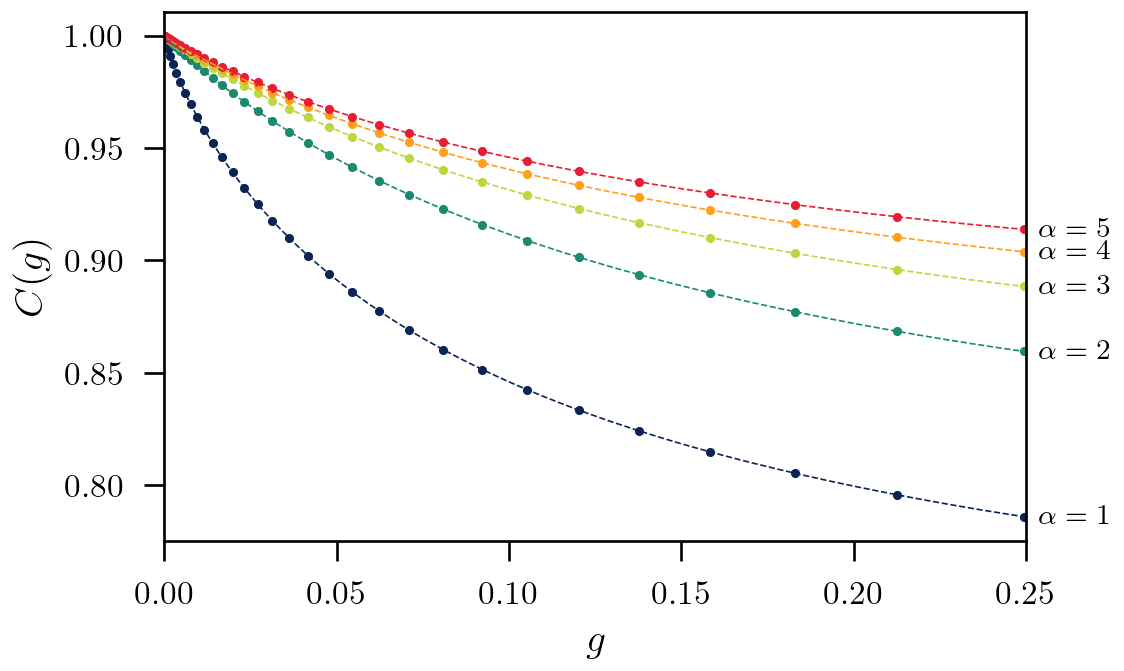

In [247]:
colors=["#0B2456","#1A896F","#bdd73c","#FF9F1C","#E71D36"]
def fitfunc1(x,b,c,d):
    return b*x**4+c*x**2+d
vs=[-1.65,-1.6,-1.55,-1.5,-1.45,-1.4,-1.35,-1.3,-1.25,-1.2,-1.15,-1.1,-1.05,-1,-.95,-.9,-.85,-.8,-.75,-.7,-.65,-.6,-.55,-.5,-.45,-.4,-.35,-.3,-.25,-.2,-.15,-.1,-.05]
plt.style.reload_library()
with plt.style.context('../include/IOP.mplstyle'):
    fig,ax=plt.subplots()
    for i, α in enumerate([1,2,3,4,5]):
        cg=[]
        gvals = []
        cerror=[]
        for v in vs:
            nval=1
            N, oneN, ent = loaddata(α,v,nval)
            oneN=np.array(oneN)
            ent = np.array(ent)
            ent=ent.reshape((-1,))
            if v == -1.65:
                fit, cov= curve_fit(fitfunc1, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                cg.append(fit[2])
                cerror.append(perr[2]) 
            else:
                scalingv=partial(scalingform,v=v)
                fit, cov= curve_fit(scalingv, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                cg.append(fit[4])
                cerror.append(perr[4]) 
            gvals.append(gammasq(v)/2)
            if v==-1.65:
                plt.text(.275,fit[2],rf"$\alpha={α}$",ha="right",va="center",size='x-small')
        f=interpolate.interp1d(gvals,cg,kind='quadratic')
        gvals=np.array(gvals)
        ginterp=np.linspace(min(gvals),max(gvals),1000)
        plt.plot(ginterp,f(ginterp),linestyle='--',linewidth=.5,color=colors[i])
        plt.scatter(gvals,cg,marker='o',s=3,color=colors[i])
    ax.set_xlabel(r'$g$')
    ax.set_ylabel(r'$C(g)$')
    ax.set_xlim(0,.25)
    plt.savefig('cofg.pdf')
    plt.show()

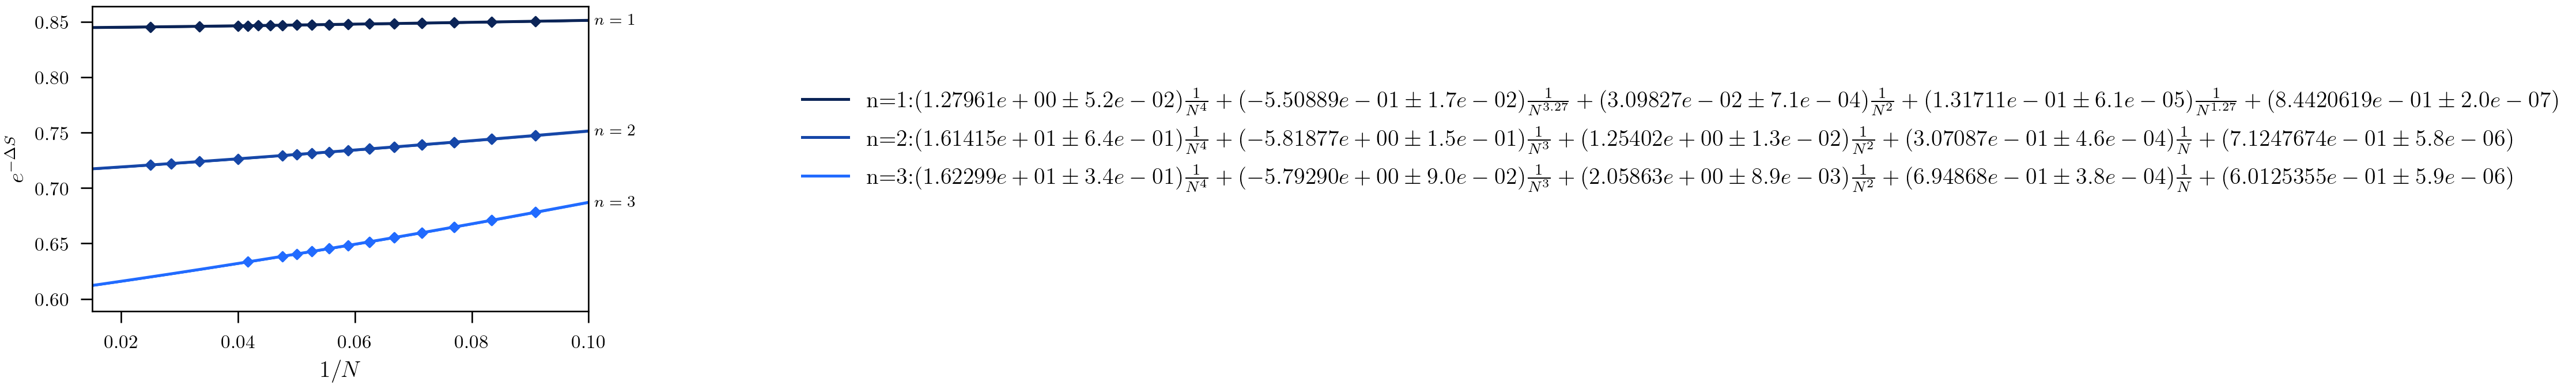

In [257]:
#colorsblue=['#000000','#113782','#1749AD','#216BFF']
colorsblue=['#0B2457','#1647A8','#216BFF']

def fitfunc23(x,a,b,c,d,e):
    return a*x**4+b*x**3+c*x**2+d*x+e
for v in [1.75]:
    for α in [1]:
        plt.style.reload_library()
        with plt.style.context('../include/IOP.mplstyle'):
            fig,ax=plt.subplots()
            for i, nval in enumerate([1,2,3]):
                if nval == 1:
                    N, oneN, ent = loaddata(α,v,nval)
                    oneN=np.array(oneN)
                    ent = np.array(ent)
                    ent=ent.reshape((-1,))
                    fitfunc175=scalingv=partial(scalingform,v=v)
                    fit, cov= curve_fit(fitfunc175, oneN, ent)
                    perr = np.sqrt(np.diag(cov))
                    ratios=np.linspace(0,.1,1000)
                    plt.plot(ratios,fitfunc175(ratios,*fit),color=colorsblue[i],label=f'n={nval}:'+(r'$(%.5e\pm%.1e)\frac{1}{N^{4}}+(%.5e\pm%.1e)\frac{1}{N^{3.27}}+(%.5e\pm%.1e)\frac{1}{N^{2}}+(%.5e\pm%.1e)\frac{1}{N^{1.27}}+(%.7e\pm%.1e)$'%(fit[0],perr[0],fit[1],perr[1],fit[2],perr[2],fit[3],perr[3],fit[4],perr[4])))
                    plt.fill_between(ratios,fitfunc175(ratios,*fit),fitfunc175(ratios,*fit+perr),color=colorsblue[i],alpha=.5)
                    plt.fill_between(ratios,fitfunc175(ratios,*fit),fitfunc175(ratios,*fit-perr),color=colorsblue[i],alpha=.5)  
                    for j in range(len(ent)):
                        plt.scatter(oneN[j],ent[j],marker='D',color=colorsblue[i*2],s=12)
                    plt.text(.108,fitfunc175(.1,*fit),rf"$n={nval}$",ha="right",va="center",size='x-small')
                else:
                    N, oneN, ent = loaddata(α,v,nval)
                    oneN=np.array(oneN)
                    ent = np.array(ent)
                    ent=ent.reshape((-1,))
                    fit, cov= curve_fit(fitfunc23, oneN, ent)
                    perr = np.sqrt(np.diag(cov))
                    ratios=np.linspace(0,.1,1000)
                    plt.plot(ratios,fitfunc23(ratios,*fit),color=colorsblue[i],label=f'n={nval}:'+(r'$(%.5e\pm%.1e)\frac{1}{N^{4}}+(%.5e\pm%.1e)\frac{1}{N^{3}}+(%.5e\pm%.1e)\frac{1}{N^{2}}+(%.5e\pm%.1e)\frac{1}{N}+(%.7e\pm%.1e)$'%(fit[0],perr[0],fit[1],perr[1],fit[2],perr[2],fit[3],perr[3],fit[4],perr[4])))
                    plt.fill_between(ratios,fitfunc23(ratios,*fit),fitfunc23(ratios,*fit+perr),color=colorsblue[i],alpha=.5)
                    plt.fill_between(ratios,fitfunc23(ratios,*fit),fitfunc23(ratios,*fit-perr),color=colorsblue[i],alpha=.5)  
                    for j in range(len(ent)):
                        plt.scatter(oneN[j],ent[j],marker='D',color=colorsblue[i],s=12)
                    plt.text(.108,fitfunc23(.1,*fit),rf"$n={nval}$",ha="right",va="center",size='x-small')
            plt.legend(loc="upper center",bbox_to_anchor=(3.2,.8))
            ax.set_xlabel(r'$1/N$')
            ax.set_ylabel(r'$e^{-\Delta S}$')
            plt.xlim(.015,.10)
            #plt.savefig('alpha1v1.75diffn.pdf')
            plt.show()


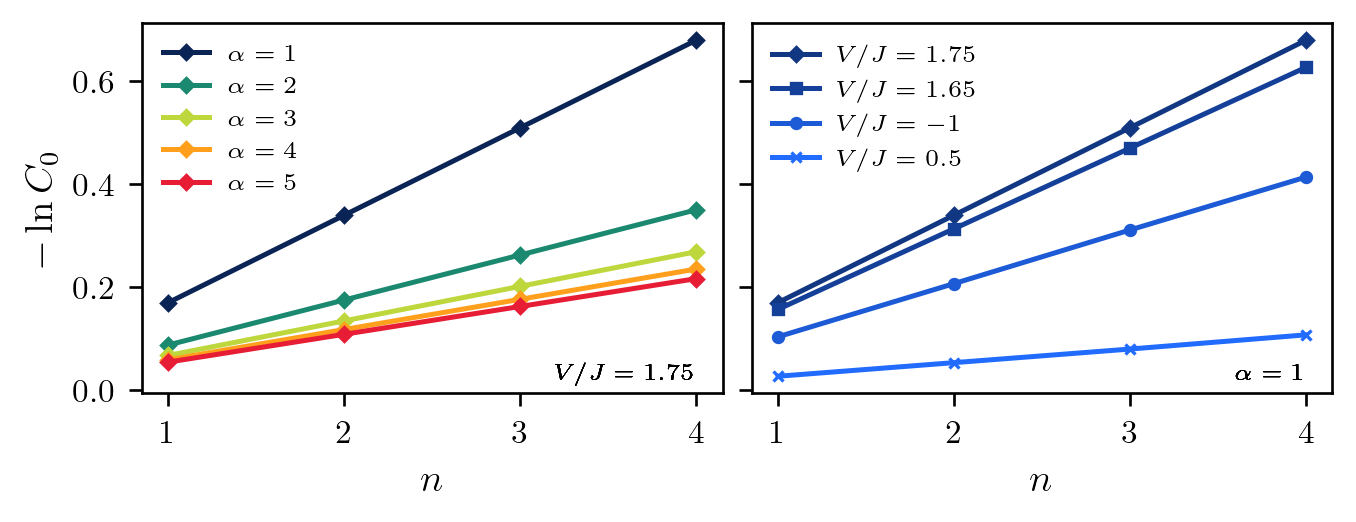

In [350]:
#colorsblue=['#000000','#113782','#1749AD','#216BFF']
colorsblue=['#113782','#144099','#1C5AD6','#216BFF']
markers=['x','o','s','D']
markers=['D','s','o','x']
def fitfunc23(x,a,b,c,d,e):
    return a*x**4+b*x**3+c*x**2+d*x+e

plt.style.reload_library()
with plt.style.context('../include/IOP.mplstyle'):
    fig, axs = plt.subplots(1,2,sharey=True)
    plt.subplots_adjust(wspace=.05) 
    ax1 = axs[1]
    α=1
    for i,v in enumerate([1.75,1.65,-1,.5]):
        constants=[]
        for nval in [1,2,3,4]:
            if nval == 1:
                N, oneN, ent = loaddata(α,v,nval)
                oneN=np.array(oneN)
                ent = np.array(ent)
                ent=ent.reshape((-1,))
                if v == -1.65:
                    scalingv=fitfunc1
                else:
                    scalingv=partial(scalingform,v=v)
                fit, cov= curve_fit(scalingv, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                constants.append(-np.log(fit[-1]))
                ratios=np.linspace(0,.1,1000)
            else:
                N, oneN, ent = loaddata(α,v,nval)
                oneN=np.array(oneN)
                ent = np.array(ent)
                ent=ent.reshape((-1,))
                fit, cov= curve_fit(fitfunc23, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                constants.append(-np.log(fit[-1]))
        ax1.plot([1,2,3,4],constants,color=colorsblue[i],marker=markers[i],ms=3,label=rf'$V/J={v}$')
    ax1.set_xlabel(r'$n$')
    ax1.legend(fontsize='xx-small')
    ax2=axs[0]
    v=1.75
    colors=["#0B2456","#1A896F","#bdd73c","#FF9F1C","#E71D36"]
    for i,α in enumerate([1,2,3,4,5]):
        constants=[]
        for nval in [1,2,3,4]:
            if nval == 1:
                N, oneN, ent = loaddata(α,v,nval)
                oneN=np.array(oneN)
                ent = np.array(ent)
                ent=ent.reshape((-1,))
                if v == -1.65:
                    scalingv=fitfunc1
                else:
                    scalingv=partial(scalingform,v=v)
                fit, cov= curve_fit(scalingv, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                constants.append(-np.log(fit[-1]))
                ratios=np.linspace(0,.1,1000)
            else:
                N, oneN, ent = loaddata(α,v,nval)
                oneN=np.array(oneN)
                ent = np.array(ent)
                ent=ent.reshape((-1,))
                fit, cov= curve_fit(fitfunc23, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                constants.append(-np.log(fit[-1]))
        ax2.plot([1,2,3,4],constants,color=colors[i],marker='D',ms=3,label=rf'$\alpha={α}$')
        ax2.legend(loc='upper left', fontsize='xx-small')
        ax2.set_xlabel(r'$n$')
        ax2.set_ylabel(r'$-\ln{C_0}$')
        ax2.text(3.2,.02,r'$V/J=1.75$',fontsize='xx-small')
        ax1.text(3.6,.02,r'$\alpha=1$',fontsize='xx-small')
    plt.savefig('linearn.pdf')

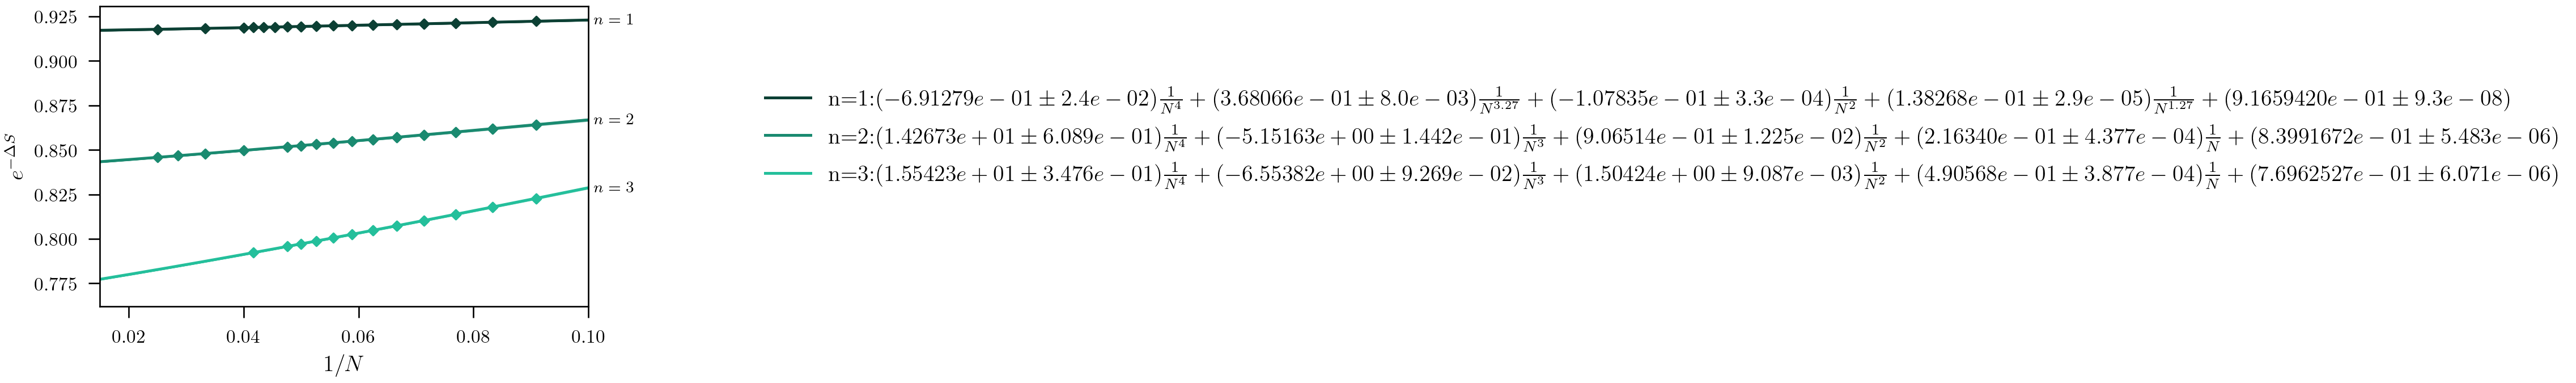

In [258]:
colorsgreen=['#0C4034','#1A8A70','#24BF9B']
def fitfunc23(x,a,b,c,d,e):
    return a*x**4+b*x**3+c*x**2+d*x+e
for v in [1.75]:
    for α in [2]:
        plt.style.reload_library()
        with plt.style.context('../include/IOP.mplstyle'):
            fig,ax=plt.subplots()
            for i, nval in enumerate([1,2,3]):
                if nval == 1:
                    N, oneN, ent = loaddata(α,v,nval)
                    oneN=np.array(oneN)
                    ent = np.array(ent)
                    ent=ent.reshape((-1,))
                    fitfunc175=scalingv=partial(scalingform,v=v)
                    fit, cov= curve_fit(fitfunc175, oneN, ent)
                    perr = np.sqrt(np.diag(cov))
                    ratios=np.linspace(0,.1,1000)
                    plt.plot(ratios,fitfunc175(ratios,*fit),color=colorsgreen[i],label=f'n={nval}:'+(r'$(%.5e\pm%.1e)\frac{1}{N^{4}}+(%.5e\pm%.1e)\frac{1}{N^{3.27}}+(%.5e\pm%.1e)\frac{1}{N^{2}}+(%.5e\pm%.1e)\frac{1}{N^{1.27}}+(%.7e\pm%.1e)$'%(fit[0],perr[0],fit[1],perr[1],fit[2],perr[2],fit[3],perr[3],fit[4],perr[4])))
                    plt.fill_between(ratios,fitfunc175(ratios,*fit),fitfunc175(ratios,*fit+perr),color=colorsgreen[i],alpha=.5)
                    plt.fill_between(ratios,fitfunc175(ratios,*fit),fitfunc175(ratios,*fit-perr),color=colorsgreen[i],alpha=.5)  
                    for j in range(len(ent)):
                        plt.scatter(oneN[j],ent[j],marker='D',color=colorsgreen[i],s=12)
                    plt.text(.108,fitfunc175(.1,*fit),rf"$n={nval}$",ha="right",va="center",size='x-small')
                else:
                    N, oneN, ent = loaddata(α,v,nval)
                    oneN=np.array(oneN)
                    ent = np.array(ent)
                    ent=ent.reshape((-1,))
                    fit, cov= curve_fit(fitfunc23, oneN, ent)
                    perr = np.sqrt(np.diag(cov))
                    ratios=np.linspace(0,.1,1000)
                    plt.plot(ratios,fitfunc23(ratios,*fit),color=colorsgreen[i],label=f'n={nval}:'+(r'$(%.5e\pm%.3e)\frac{1}{N^{4}}+(%.5e\pm%.3e)\frac{1}{N^{3}}+(%.5e\pm%.3e)\frac{1}{N^{2}}+(%.5e\pm%.3e)\frac{1}{N}+(%.7e\pm%.3e)$'%(fit[0],perr[0],fit[1],perr[1],fit[2],perr[2],fit[3],perr[3],fit[4],perr[4])))
                    plt.fill_between(ratios,fitfunc23(ratios,*fit),fitfunc23(ratios,*fit+perr),color=colorsgreen[i],alpha=.5)
                    plt.fill_between(ratios,fitfunc23(ratios,*fit),fitfunc23(ratios,*fit-perr),color=colorsgreen[i],alpha=.5)  
                    for j in range(len(ent)):
                        plt.scatter(oneN[j],ent[j],marker='D',color=colorsgreen[i],s=12)
                    plt.text(.108,fitfunc23(.1,*fit),rf"$n={nval}$",ha="right",va="center",size='x-small')
            plt.legend(loc="upper center",bbox_to_anchor=(3.2,.8))
            ax.set_xlabel(r'$1/N$')
            ax.set_ylabel(r'$e^{-\Delta S}$')
            plt.xlim(.015,.10)
            plt.savefig('alpha2v1.75diffn.pdf')
            plt.show()